In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import date
from lmfit import Model
from scipy.interpolate import UnivariateSpline
import importlib
'imports done1'

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


'imports done1'

In [2]:
data = pd.read_csv('../data/11-04-2019/total_cases.csv')
data.fillna(0, inplace = True)
data.head()

,date,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,United States,United States Virgin Islands,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,2019-12-31,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-01,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-02,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-03,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-04,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
import fitting_helper
importlib.reload(fitting_helper)
from fitting_helper import preprocess

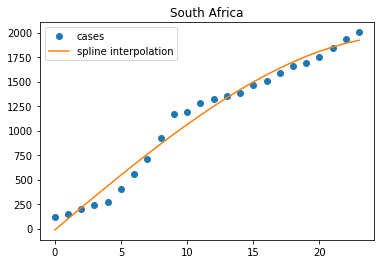

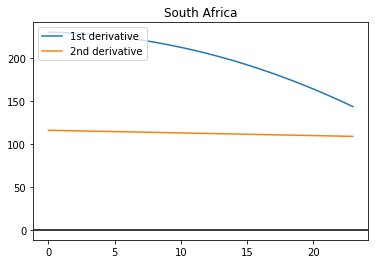

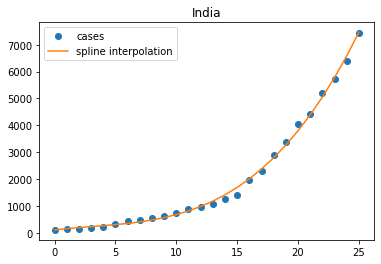

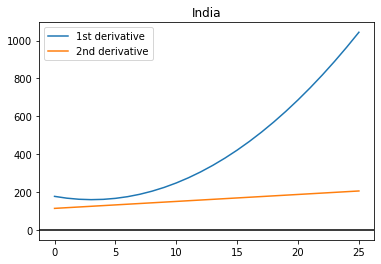

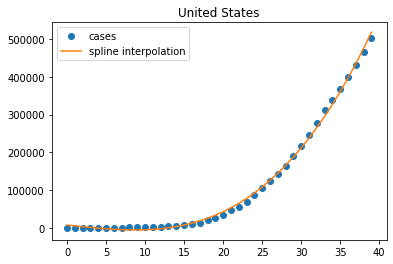

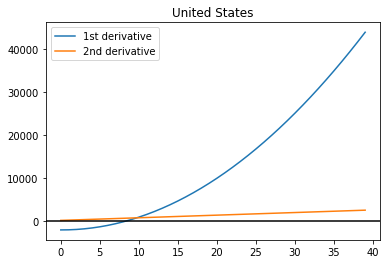

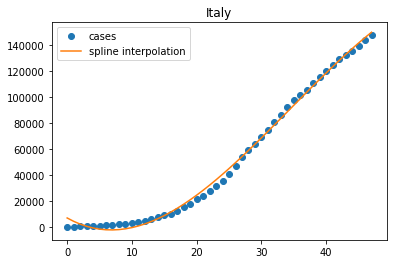

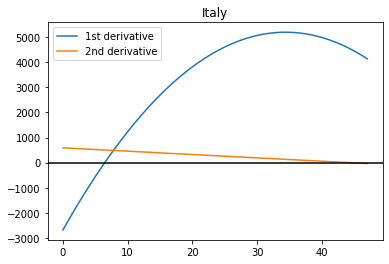

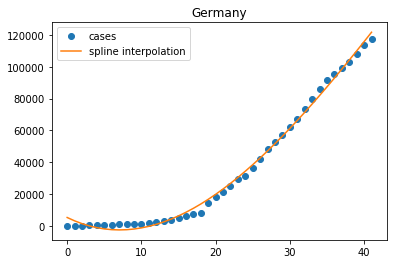

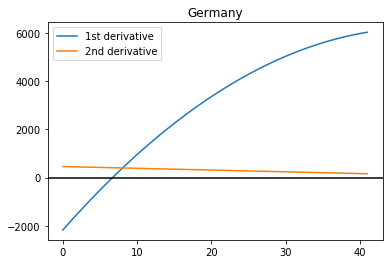

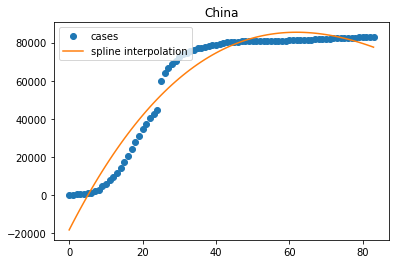

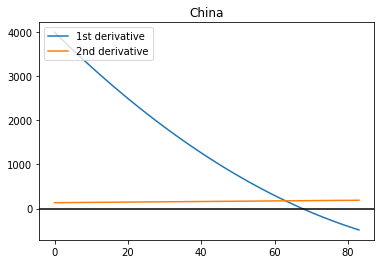

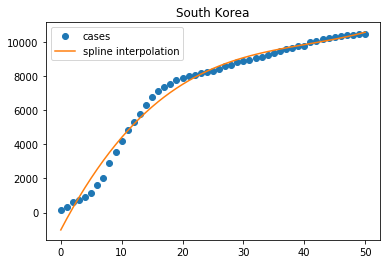

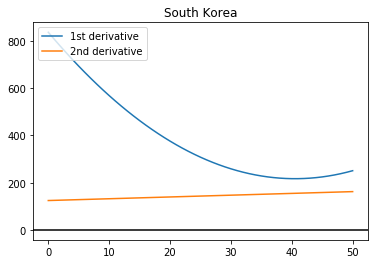

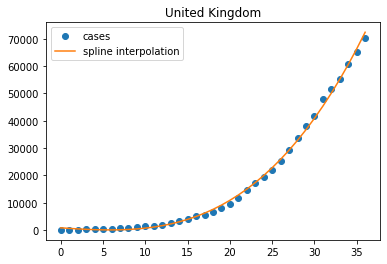

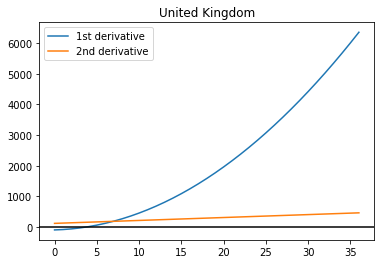

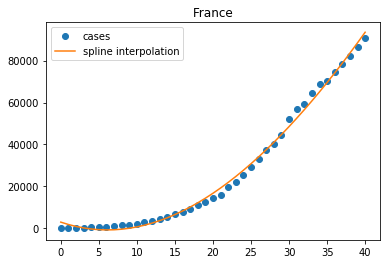

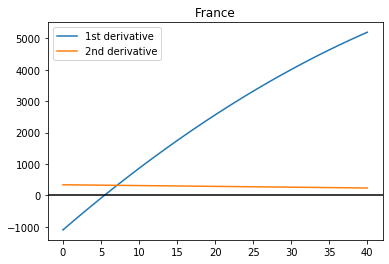

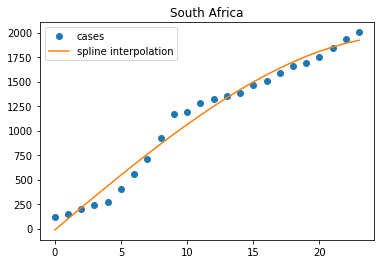

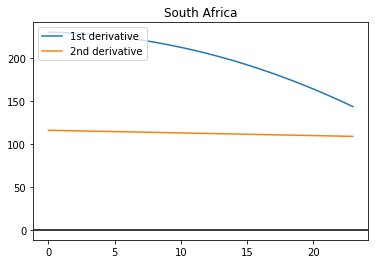

In [22]:
for country in ['South Africa', 'India', 'United States', 'Italy', 'Germany', 'China', 'South Korea', 'United Kingdom', 'France', 'South Africa']:

    country_data, output_scaler = preprocess(data, 'date', country, forecast = 30)
    
    X = country_data[country_data.forecast == 0]['processed_date'].values.reshape((-1, ))
    Y = country_data[country_data.forecast == 0]['processed_' + country].values.reshape((-1, ))
    
    
    Y_spline = (UnivariateSpline(X, Y,s=25,k=3))
    Y_1D = Y_spline.derivative(n=1)(X).reshape((-1, 1))
    Y_2D = Y_spline.derivative(n=2)(X).reshape((-1, 1))

    

    plt.title(country)
    plt.plot(X, output_scaler.inverse_transform(Y.reshape((-1, 1))), 'o', label = 'cases')
    plt.plot(X, output_scaler.inverse_transform(Y_spline(X).reshape((-1, 1))), '-', label = 'spline interpolation')
    plt.legend(loc='upper left')
    plt.show()


    plt.title(country)
    plt.plot(X, output_scaler.inverse_transform(Y_1D), label = '1st derivative')
    plt.plot(X,  output_scaler.inverse_transform(Y_2D), label = '2nd derivative')
    plt.axhline(0, color = 'black')
    plt.legend(loc='upper left')
    plt.show()
    



## Gaussian CDF forecasting

/home/ajviswan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ajviswan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ajviswan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

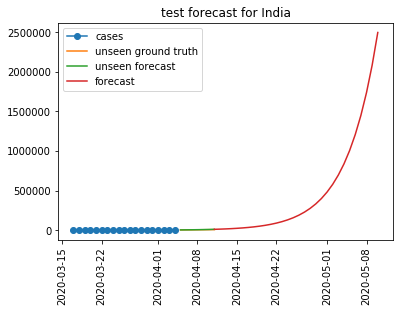

KeyError: 'processed_India_cases'

In [46]:
from datetime import timedelta

import fitting_helper
importlib.reload(fitting_helper)
from fitting_helper import preprocess
from scipy.stats import norm

def gaussian_cdf(x, amp, cen, wid):
    value = norm.cdf(x, cen, wid) * amp
    return value

loss = 0
countries = ['India', 'United States', 'Italy', 'United Kingdom', 'France', 'South Africa']
for country in countries:
    gmodel = Model(gaussian_cdf)
    params = gmodel.make_params(cen=0, amp=1, wid=1)
    country_data, output_scaler = preprocess(data, 'date', country, forecast = 60)

    italy_data, case_scaler = preprocess(data, 'date', f'{country}', forecast = 30)
    #print(italy_data)

    past_data = italy_data[italy_data.forecast == 0]
    present_data = italy_data[italy_data.forecast == 1]
    forecast_data = italy_data[italy_data.forecast == 2]
    
    X = past_data['processed_date'].values
    Y = past_data[f'processed_{country}'].values

    test_model = Model(gaussian_cdf)
    result = test_model.fit(Y, x=X, amp = 1, cen = 0, wid = 1)
    past_data['test_predictions'] = result.best_fit
    present_data['test_predictions'] = result.eval(x=present_data['processed_date'].values)
    forecast_data['test_predictions'] = result.eval(x=forecast_data['processed_date'].values)
    plt.title(f'test forecast for {country}')
    plt.plot(pd.to_datetime(past_data['date']), output_scaler.inverse_transform(Y.reshape((-1, 1))), '-o', label = 'cases')
    plt.plot(pd.to_datetime(present_data['date']), output_scaler.inverse_transform(present_data[f'processed_{country}'].values.reshape((-1, 1))), label = 'unseen ground truth')
    plt.plot(pd.to_datetime(present_data['date']), output_scaler.inverse_transform(present_data['test_predictions'].values.reshape((-1, 1))), label = 'unseen forecast')
    plt.plot(pd.to_datetime(forecast_data['date']), output_scaler.inverse_transform(forecast_data['test_predictions'].values.reshape((-1, 1))), label = 'forecast')
    plt.xticks(rotation=90)
    plt.legend(loc='upper left')
    plt.show()
    loss += abs(present_data[f'processed_{country}_cases'].values - present_data[f'predictions'].values).mean()

loss / len(countries)